This notebook contains code to extract features from the audio signals.

In [1]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
data_dir = 'C:/Users/HP/Multimodal/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

In [3]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [4]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

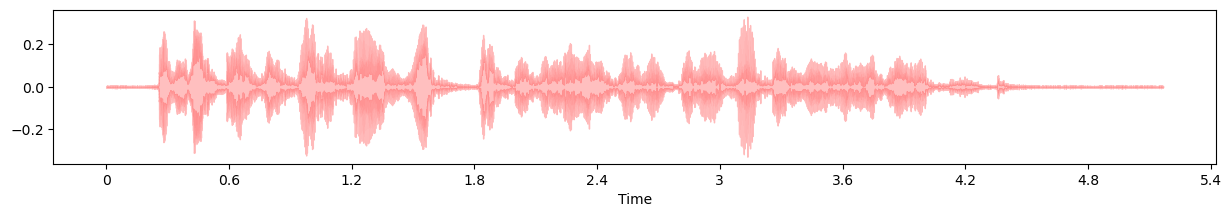

In [5]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y, sr=sr,  alpha=0.25, color='r')

In [6]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.02966
Signal std dev = 0.04784


RMS mean = 0.03710
RMS std dev = 0.03012


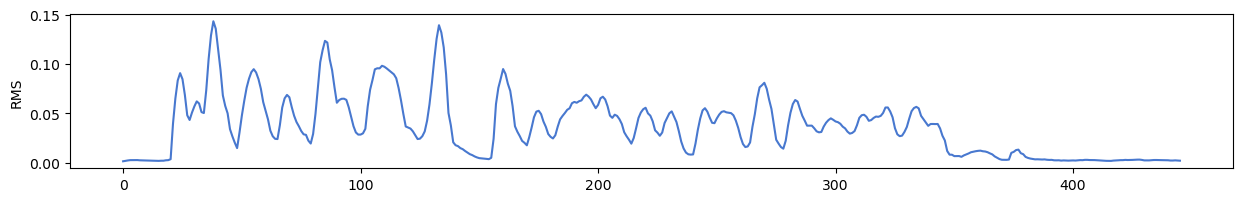

In [7]:
rms = librosa.feature.rms(y=y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rms)
plt.ylabel('RMS')
print('RMS mean = {:.5f}'.format(np.mean(rms)))
print('RMS std dev = {:.5f}'.format(np.std(rms)))

In [8]:
from IPython.display import Audio
Audio(y, rate=44100)

In [9]:
silence = 0
for e in rms:
    if e <= 0.4 * np.mean(rms):
        silence += 1
print(silence/float(len(rms)))

0.31614349775784756


In [10]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-8.629574e-06

In [11]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

521.5495696265757

In [12]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

371.4461768311845

In [13]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rms_mean', 'rms_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [14]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'C:/Users/HP/Multimodal/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [15]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rms = librosa.feature.rms(y=y + 0.0001)[0]
                feature_list.append(np.mean(rms))  # rms_mean
                feature_list.append(np.std(rms))  # rms_std

                silence = 0
                for e in rms:
                    if e <= 0.4 * np.mean(rms):
                        silence += 1
                silence /= float(len(rms))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

df_features.to_csv('C:/Users/HP/Multimodal/pre-processed/audio_features.csv', index=False)

0it [00:00, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1it [00:00,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2it [00:01,  1.78it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
3it [00:02,  1.33it/

25it [00:27,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
26it [00:29,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
27it [00:30,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
28it [00:32, 

50it [00:52,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
51it [00:52,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
52it [00:53,  1.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
53it [00:54, 

75it [01:11,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
76it [01:12,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
77it [01:12,  1.38it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
78it [01:13, 

100it [01:28,  1.59it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
101it [01:28,  1.84it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
102it [01:29,  2.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
103it [01:

125it [01:44,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
126it [01:44,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
127it [01:45,  1.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
128it [01:

150it [01:59,  1.78it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
151it [02:00,  1.75it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
152it [02:01,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
153it [02:

175it [02:16,  1.67it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
176it [02:18,  1.01s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
177it [02:19,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
178it [02:

200it [02:31,  2.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
201it [02:33,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
202it [02:34,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
203it [02:

225it [02:51,  2.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
226it [02:51,  2.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
227it [02:52,  2.70it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
228it [02:

250it [03:17,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
251it [03:19,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
252it [03:21,  1.57s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
253it [03:

275it [03:55,  1.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
276it [03:56,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
277it [03:58,  1.53s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
278it [03:

300it [04:37,  1.95it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
301it [04:38,  1.82it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
302it [04:38,  2.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
303it [04:

325it [05:07,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
326it [05:08,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
327it [05:10,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
328it [05:

350it [05:36,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
351it [05:37,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
352it [05:38,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
353it [05:

375it [06:02,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
376it [06:03,  1.07s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
377it [06:04,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
378it [06:

400it [06:37,  1.76s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
401it [06:39,  1.98s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
402it [06:40,  1.50s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
403it [06:

425it [07:11,  1.68s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
426it [07:13,  1.91s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
427it [07:14,  1.52s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
428it [07:

450it [07:47,  1.69s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
451it [07:48,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
452it [07:48,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
453it [07:

475it [08:09,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
476it [08:10,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
477it [08:11,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
478it [08:

500it [08:37,  1.77s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
501it [08:38,  1.56s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
502it [08:39,  1.29s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
503it [08:

525it [09:05,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
526it [09:07,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
527it [09:08,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
528it [09:

550it [09:48,  2.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
551it [09:48,  2.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
552it [09:49,  2.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
553it [09:

575it [10:12,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
576it [10:12,  1.55it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
577it [10:14,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
578it [10:

600it [10:48,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
601it [10:50,  1.48s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
602it [10:52,  1.65s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
603it [10:

625it [11:28,  1.55s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
626it [11:31,  1.97s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
627it [11:31,  1.57s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
628it [11:

650it [12:00,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
651it [12:02,  1.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
652it [12:03,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
653it [12:

675it [12:28,  1.95s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
676it [12:29,  1.80s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
677it [12:30,  1.52s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
678it [12:

700it [12:57,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
701it [12:59,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
702it [12:59,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
703it [12:

725it [13:21,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
726it [13:23,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
727it [13:23,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
728it [13:

750it [13:55,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
751it [13:57,  1.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
752it [13:58,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
753it [13:

Some exception occured


C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
772it [14:32,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
773it [14:32,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
774it [14:34,  1.12s/it]C:\Users\H

796it [14:57,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
797it [14:57,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
798it [14:58,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
799it [14:

821it [15:25,  1.87s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
822it [15:27,  1.84s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
823it [15:28,  1.54s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
824it [15:

846it [15:55,  1.72s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
847it [15:58,  1.93s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
848it [16:02,  2.69s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
849it [16:

871it [16:28,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
872it [16:28,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
873it [16:29,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
874it [16:

896it [16:49,  1.38it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
897it [16:49,  1.61it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
898it [16:50,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
899it [16:

921it [17:11,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
922it [17:13,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
923it [17:13,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
924it [17:

946it [17:33,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
947it [17:35,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
948it [17:35,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
949it [17:

971it [17:58,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
972it [17:59,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
973it [18:00,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
974it [18:

996it [18:25,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
997it [18:26,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
998it [18:28,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
999it [18:

1021it [18:56,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1022it [18:57,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1023it [19:00,  1.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1024it 

1046it [19:25,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1047it [19:26,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1048it [19:27,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1049it 

1071it [19:52,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1072it [19:54,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1073it [19:55,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1074it 

1096it [20:11,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1097it [20:14,  1.46s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1098it [20:14,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1099it 

1121it [20:31,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1122it [20:33,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1123it [20:33,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1124it 

1146it [20:59,  1.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1147it [21:02,  1.63s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1148it [21:02,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1149it 

1171it [21:14,  1.90it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1172it [21:15,  2.00it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1173it [21:15,  2.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1174it 

1196it [21:44,  2.50s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1197it [21:45,  2.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1198it [21:46,  1.67s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1199it 

1221it [22:03,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1222it [22:03,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1223it [22:04,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1224it 

1246it [22:32,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1247it [22:34,  1.32s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1248it [22:36,  1.65s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1249it 

1271it [23:03,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1272it [23:03,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1273it [23:05,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1274it 

1296it [23:25,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1297it [23:26,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1298it [23:27,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1299it 

1321it [23:55,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1322it [23:55,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1323it [23:56,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1324it 

1346it [24:27,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1347it [24:28,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1348it [24:30,  1.49s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1349it 

1371it [24:56,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1372it [24:58,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1373it [25:01,  2.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1374it 

1396it [25:28,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1397it [25:29,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1398it [25:30,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1399it 

1421it [25:56,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1422it [25:57,  1.31it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1423it [25:57,  1.38it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1424it 

1446it [26:29,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1447it [26:31,  1.56s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1448it [26:32,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1449it 

1471it [27:24,  2.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1472it [27:24,  1.75s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1473it [27:25,  1.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1474it 

1496it [27:46,  1.83s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1497it [27:46,  1.46s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1498it [27:47,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1499it 

1521it [28:24,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1522it [28:25,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1523it [28:27,  1.29s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1524it 

1546it [29:12,  1.81s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1547it [29:12,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1548it [29:13,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1549it 

1571it [29:52,  1.75s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1572it [29:52,  1.35s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1573it [29:53,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1574it 

1596it [30:27,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1597it [30:29,  1.44s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1598it [30:29,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1599it 

1621it [30:58,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1622it [30:58,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1623it [31:00,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1624it 

1646it [31:32,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1647it [31:33,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1648it [31:34,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1649it 

1671it [31:53,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1672it [31:53,  1.22it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1673it [31:54,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1674it 

1696it [32:17,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1697it [32:17,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1698it [32:17,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1699it 

1721it [32:41,  1.51s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1722it [32:43,  1.73s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1723it [32:45,  1.83s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1724it 

1746it [33:10,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1747it [33:11,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1748it [33:12,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1749it 

1771it [33:31,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1772it [33:33,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1773it [33:35,  1.35s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1774it 

1796it [34:05,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1797it [34:06,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1798it [34:08,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1799it 

2it [00:04,  1.95s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
3it [00:05,  1.55s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
4it [00:05,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
5it [00:07,  1.3

27it [00:38,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
28it [00:40,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
29it [00:40,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
30it [00:41, 

52it [01:09,  1.54s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
53it [01:09,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
54it [01:12,  1.65s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
55it [01:13, 

77it [02:00,  1.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
78it [02:01,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
79it [02:01,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
80it [02:03, 

102it [02:40,  1.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
103it [02:41,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
104it [02:41,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
105it [02:

127it [03:07,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
128it [03:09,  1.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
129it [03:11,  1.52s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
130it [03:

152it [03:58,  2.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
153it [03:59,  2.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
154it [04:01,  1.92s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
155it [04:

177it [04:56,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
178it [04:56,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
179it [05:01,  2.35s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
180it [05:

202it [05:45,  1.94s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
203it [05:48,  2.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
204it [05:50,  2.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
205it [05:

227it [06:34,  1.61s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
228it [06:35,  1.31s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
229it [06:36,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
230it [06:

252it [07:13,  2.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
253it [07:14,  2.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
254it [07:16,  1.89s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
255it [07:

277it [07:48,  1.71s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
278it [07:48,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
279it [07:50,  1.61s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
280it [07:

302it [08:07,  1.69it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
303it [08:08,  1.79it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
304it [08:08,  1.78it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
305it [08:

327it [08:26,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
328it [08:27,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
329it [08:27,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
330it [08:

352it [09:04,  1.91s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
353it [09:06,  1.78s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
354it [09:07,  1.72s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
355it [09:

377it [09:33,  1.01s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
378it [09:33,  1.22it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
379it [09:34,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
380it [09:

402it [09:57,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
403it [09:58,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
404it [09:59,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
405it [09:

427it [10:23,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
428it [10:24,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
429it [10:26,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
430it [10:

452it [10:56,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
453it [10:56,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
454it [10:59,  1.57s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
455it [11:

477it [11:29,  2.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
478it [11:30,  1.87s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
479it [11:32,  1.82s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
480it [11:

502it [11:50,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
503it [11:52,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
504it [11:53,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
505it [11:

527it [12:21,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
528it [12:21,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
529it [12:22,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
530it [12:

552it [12:48,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
553it [12:48,  1.35it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
554it [12:49,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
555it [12:

577it [13:33,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
578it [13:33,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
579it [13:34,  1.35it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
580it [13:

602it [13:58,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
603it [13:59,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
604it [14:01,  1.33s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
605it [14:

627it [14:33,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
628it [14:35,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
629it [14:36,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
630it [14:

652it [15:16,  1.74s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
653it [15:17,  1.49s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
654it [15:18,  1.55s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
655it [15:

677it [15:51,  1.63s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
678it [15:53,  1.83s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
679it [15:56,  1.95s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
680it [15:

702it [16:21,  1.61s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
703it [16:21,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
704it [16:24,  1.68s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
705it [16:

727it [16:47,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
728it [16:48,  1.50it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
729it [16:49,  1.43it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
730it [16:

752it [17:05,  1.43it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
753it [17:07,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
754it [17:07,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
755it [17:

777it [17:27,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
778it [17:28,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
779it [17:28,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
780it [17:

802it [17:50,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
803it [17:51,  1.55it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
804it [17:52,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
805it [17:

827it [18:06,  1.86it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
828it [18:07,  1.56it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
829it [18:07,  1.79it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
830it [18:

852it [18:28,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
853it [18:29,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
854it [18:30,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
855it [18:

877it [18:47,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
878it [18:47,  1.65it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
879it [18:48,  1.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
880it [18:

902it [19:04,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
903it [19:04,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
904it [19:05,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
905it [19:

927it [19:23,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
928it [19:24,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
929it [19:24,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
930it [19:

952it [19:45,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
953it [19:46,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
954it [19:48,  1.12s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
955it [19:

977it [20:15,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
978it [20:16,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
979it [20:17,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
980it [20:

1002it [20:32,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1003it [20:33,  1.33it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1004it [20:34,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1005it 

1027it [20:55,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1028it [20:57,  1.29s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1029it [20:58,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1030it 

1052it [21:23,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1053it [21:24,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1054it [21:24,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1055it 

1077it [21:55,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1078it [21:56,  1.29s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1079it [21:58,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1080it 

1102it [22:26,  1.51s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1103it [22:27,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1104it [22:27,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1105it 

1127it [22:45,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1128it [22:47,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1129it [22:49,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1130it 

1152it [23:05,  2.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1153it [23:05,  2.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1154it [23:07,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1155it 

1177it [23:46,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1178it [23:47,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1179it [23:48,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1180it 

1202it [24:04,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1203it [24:04,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1204it [24:05,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1205it 

1227it [24:25,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1228it [24:26,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1229it [24:27,  1.31it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1230it 

1252it [25:00,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1253it [25:01,  1.34s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1254it [25:02,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1255it 

1277it [25:16,  1.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1278it [25:17,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1279it [25:18,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1280it 

1302it [25:44,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1303it [25:45,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1304it [25:46,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1305it 

1327it [26:09,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1328it [26:10,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1329it [26:11,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1330it 

1352it [26:33,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1353it [26:34,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1354it [26:36,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1355it 

1377it [27:03,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1378it [27:04,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1379it [27:06,  1.46s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1380it 

1402it [27:35,  1.73s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1403it [27:37,  1.80s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1404it [27:38,  1.54s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1405it 

1427it [27:54,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1428it [27:55,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1429it [27:55,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1430it 

1452it [28:24,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1453it [28:25,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1454it [28:28,  1.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1455it 

1477it [28:59,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1478it [29:00,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1479it [29:01,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1480it 

1502it [29:47,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1503it [29:47,  1.61it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1504it [29:48,  1.83it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1505it 

1527it [30:08,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1528it [30:09,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1529it [30:11,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1530it 

1552it [30:39,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1553it [30:40,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1554it [30:42,  1.60s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1555it 

1577it [31:20,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1578it [31:22,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1579it [31:24,  1.69s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1580it 

1602it [31:53,  1.91s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1603it [31:55,  1.95s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1604it [31:56,  1.62s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1605it 

1627it [32:21,  1.67s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1628it [32:22,  1.33s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1629it [32:24,  1.72s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1630it 

1652it [32:52,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1653it [32:52,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1654it [32:53,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1655it 

1677it [33:12,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1678it [33:13,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1679it [33:15,  1.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1680it 

1702it [33:39,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1703it [33:40,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1704it [33:40,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1705it 

1727it [34:05,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1728it [34:06,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1729it [34:07,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1730it 

1752it [34:26,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1753it [34:26,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1754it [34:27,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1755it 

1777it [34:53,  1.07s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1778it [34:54,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1779it [34:54,  1.38it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1780it 

1802it [35:16,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1803it [35:16,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1804it [35:17,  1.50it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1805it 

16it [00:18,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
17it [00:19,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
18it [00:19,  1.47it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
19it [00:20, 

41it [00:43,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
42it [00:45,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
43it [00:45,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
44it [00:46, 

66it [01:06,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
67it [01:07,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
68it [01:07,  1.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
69it [01:07, 

91it [01:23,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
92it [01:25,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
93it [01:25,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
94it [01:26, 

116it [01:55,  1.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
117it [01:55,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
118it [01:56,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
119it [01:

141it [02:14,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
142it [02:15,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
143it [02:16,  1.35it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
144it [02:

166it [02:40,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
167it [02:41,  1.00it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
168it [02:42,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
169it [02:

191it [02:58,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
192it [02:59,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
193it [02:59,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
194it [03:

216it [03:24,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
217it [03:26,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
218it [03:27,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
219it [03:

241it [03:53,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
242it [03:54,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
243it [03:56,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
244it [03:

266it [04:18,  1.40it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
267it [04:19,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
268it [04:20,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
269it [04:

291it [04:37,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
292it [04:38,  1.29s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
293it [04:39,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
294it [04:

316it [04:56,  1.43it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
317it [04:57,  1.71it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
318it [04:57,  1.71it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
319it [04:

341it [05:10,  1.62it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
342it [05:11,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
343it [05:11,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
344it [05:

366it [05:28,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
367it [05:29,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
368it [05:30,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
369it [05:

391it [05:46,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
392it [05:48,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
393it [05:48,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
394it [05:

416it [06:05,  1.47it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
417it [06:07,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
418it [06:08,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
419it [06:

441it [06:31,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
442it [06:32,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
443it [06:33,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
444it [06:

466it [06:54,  1.59it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
467it [06:56,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
468it [06:58,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
469it [06:

491it [07:23,  1.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
492it [07:23,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
493it [07:24,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
494it [07:

516it [07:49,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
517it [07:50,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
518it [07:51,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
519it [07:

541it [08:10,  1.68it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
542it [08:11,  1.72it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
543it [08:13,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
544it [08:

566it [08:27,  1.62it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
567it [08:27,  1.56it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
568it [08:28,  1.50it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
569it [08:

591it [08:46,  1.47it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
592it [08:47,  1.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
593it [08:49,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
594it [08:

616it [09:13,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
617it [09:13,  1.66it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
618it [09:16,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
619it [09:

641it [09:51,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
642it [09:52,  1.07s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
643it [18:51, 162.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
644it [18

666it [19:14,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
667it [19:17,  1.47s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
668it [19:19,  1.69s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
669it [19:

691it [19:50,  1.76s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
692it [19:50,  1.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
693it [19:53,  1.61s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
694it [19:

716it [20:27,  1.41s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
717it [20:28,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
718it [20:29,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
719it [20:

741it [20:50,  2.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
742it [20:51,  2.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
743it [20:52,  1.84it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
744it [20:

766it [21:17,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
767it [21:17,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
768it [21:19,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
769it [21:

791it [21:49,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
792it [21:53,  2.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
793it [21:55,  1.97s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
794it [21:

816it [22:14,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
817it [22:15,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
818it [22:15,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
819it [22:

841it [22:35,  1.86it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
842it [22:36,  1.57it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
843it [22:36,  1.62it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
844it [22:

866it [23:08,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
867it [23:09,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
868it [23:09,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
869it [23:

891it [23:27,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
892it [23:28,  1.62it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
893it [23:29,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
894it [23:

916it [23:52,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
917it [23:53,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
918it [23:54,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
919it [23:

941it [24:11,  1.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
942it [24:13,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
943it [24:14,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
944it [24:

966it [24:39,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
967it [24:40,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
968it [24:41,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
969it [24:

991it [25:04,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
992it [25:05,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
993it [25:06,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
994it [25:

1016it [25:24,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1017it [25:24,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1018it [25:25,  1.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1019it 

1041it [25:44,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1042it [25:45,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1043it [25:48,  1.46s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1044it 

1066it [26:05,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1067it [26:06,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1068it [26:07,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1069it 

1091it [26:24,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1092it [26:24,  1.56it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1093it [26:27,  1.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1094it 

1116it [26:46,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1117it [26:47,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1118it [26:47,  1.40it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1119it 

1141it [27:10,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1142it [27:11,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1143it [27:11,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1144it 

1166it [27:35,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1167it [27:36,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1168it [27:37,  1.01s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1169it 

1191it [27:56,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1192it [27:57,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1193it [27:59,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1194it 

1216it [28:22,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1217it [28:23,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1218it [28:24,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1219it 

Some exception occured


C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1224it [28:29,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1225it [28:30,  1.31it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1226it [28:30,  1.39it/s]C:\User

1248it [28:47,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1249it [28:49,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1250it [28:49,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1251it 

1273it [29:06,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1274it [29:06,  1.55it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1275it [29:07,  1.65it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1276it 

1298it [29:22,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1299it [29:23,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1300it [29:23,  1.54it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1301it 

1323it [29:40,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1324it [29:40,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1325it [29:41,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1326it 

1348it [30:00,  1.69it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1349it [30:02,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1350it [30:03,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1351it 

1373it [30:25,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1374it [30:26,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1375it [30:27,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1376it 

1398it [30:43,  1.54it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1399it [30:43,  1.68it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1400it [30:44,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1401it 

1423it [31:07,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1424it [31:08,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1425it [31:09,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1426it 

1448it [31:26,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1449it [31:27,  1.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1450it [31:27,  1.70it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1451it 

1473it [31:44,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1474it [31:45,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1475it [31:45,  1.38it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1476it 

1498it [32:09,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1499it [32:11,  1.00it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1500it [32:11,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1501it 

1523it [32:39,  1.29s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1524it [32:40,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1525it [32:41,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1526it 

1548it [33:06,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1549it [33:07,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1550it [33:07,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1551it 

1573it [33:30,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1574it [33:31,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1575it [33:34,  1.35s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1576it 

1598it [33:57,  1.65it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1599it [33:58,  1.55it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1600it [33:58,  1.53it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1601it 

1623it [1:15:52, 257.69s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1624it [1:15:54, 180.76s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1625it [1:15:56, 127.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True

1648it [1:16:18,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1649it [1:16:20,  1.33s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1650it [1:16:22,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1673it [1:16:42,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1674it [1:16:45,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1675it [1:16:46,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1698it [1:17:10,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1699it [1:17:12,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1700it [1:17:13,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1723it [1:17:36,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1724it [1:17:37,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1725it [1:17:38,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1748it [1:17:58,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1749it [1:17:58,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1750it [1:17:59,  1.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1773it [1:18:23,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1774it [1:18:24,  1.44s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1775it [1:18:25,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1798it [1:18:55,  2.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1799it [1:18:57,  2.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1800it [1:18:58,  1.92s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1823it [1:19:16,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1824it [1:19:17,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1825it [1:19:17,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1848it [1:19:46,  1.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1849it [1:19:48,  1.50s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1850it [1:19:48,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1873it [1:20:24,  1.54s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1874it [1:20:24,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1875it [1:20:25,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1898it [1:20:53,  1.79s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1899it [1:20:54,  1.52s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1900it [1:20:54,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1923it [1:21:19,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1924it [1:21:20,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1925it [1:21:21,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1948it [1:21:45,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1949it [1:21:46,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1950it [1:21:47,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1973it [1:22:12,  1.54it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1974it [1:22:12,  1.62it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1975it [1:22:13,  1.83it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1998it [1:22:29,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1999it [1:22:30,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2000it [1:22:31,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2023it [1:22:49,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2024it [1:22:50,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2025it [1:22:51,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2048it [1:23:12,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2049it [1:23:12,  1.63it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2050it [1:23:13,  1.55it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2073it [1:23:28,  1.50it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2074it [1:23:28,  1.76it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2075it [1:23:29,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2098it [1:23:52,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2099it [1:23:52,  1.61it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2100it [1:23:52,  1.70it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2123it [1:24:12,  1.12s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2124it [1:24:13,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2125it [1:24:13,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

12it [00:15,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
13it [00:17,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
14it [00:17,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
15it [00:19, 

37it [00:37,  1.90it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
38it [00:38,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
39it [00:40,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
40it [00:41, 

62it [01:02,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
63it [01:02,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
64it [01:03,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
65it [01:04, 

87it [01:27,  1.07s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
88it [01:30,  1.65s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
89it [01:30,  1.35s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
90it [01:32, 

112it [01:55,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
113it [01:55,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
114it [01:55,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
115it [01:

137it [02:10,  1.53it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
138it [02:10,  1.91it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
139it [02:10,  2.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
140it [02:

162it [02:26,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
163it [02:26,  1.59it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
164it [02:27,  1.98it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
165it [02:

187it [02:42,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
188it [02:44,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
189it [02:44,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
190it [02:

212it [03:08,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
213it [03:09,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
214it [03:12,  1.60s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
215it [03:

237it [03:34,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
238it [03:36,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
239it [03:36,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
240it [03:

262it [03:54,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
263it [03:56,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
264it [03:57,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
265it [03:

287it [04:26,  2.33s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
288it [04:27,  1.92s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
289it [04:29,  1.73s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
290it [04:

312it [04:53,  1.07s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
313it [04:54,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
314it [04:55,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
315it [04:

337it [05:32,  1.31s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
338it [05:33,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
339it [05:34,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
340it [05:

362it [05:52,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
363it [05:53,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
364it [05:53,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
365it [05:

387it [17:16, 141.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
388it [17:17, 98.94s/it] C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
389it [17:18, 69.49s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
390it [1

412it [17:33,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
413it [17:33,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
414it [17:34,  1.56it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
415it [17:

437it [17:49,  1.54it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
438it [17:50,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
439it [17:50,  1.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
440it [17:

462it [18:04,  1.38it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
463it [18:06,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
464it [18:07,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
465it [18:

487it [18:25,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
488it [18:25,  1.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
489it [18:26,  1.93it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
490it [18:

512it [18:40,  1.57it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
513it [18:41,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
514it [18:42,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
515it [18:

537it [19:02,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
538it [19:02,  1.56it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
539it [19:04,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
540it [19:

562it [19:32,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
563it [19:32,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
564it [19:33,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
565it [19:

587it [19:51,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
588it [19:52,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
589it [19:53,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
590it [19:

612it [20:13,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
613it [20:14,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
614it [20:14,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
615it [20:

637it [20:35,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
638it [20:36,  1.18it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
639it [20:36,  1.33it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
640it [20:

662it [20:58,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
663it [20:59,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
664it [20:59,  1.40it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
665it [21:

687it [47:43, 57.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
688it [47:44, 40.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
689it [47:45, 28.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
690it [47:

712it [48:02,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
713it [48:03,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
714it [48:04,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
715it [48:

737it [48:22,  2.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
738it [48:22,  2.57it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
739it [48:24,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
740it [48:

762it [48:45,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
763it [48:46,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
764it [48:47,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
765it [48:

787it [49:11,  1.71it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
788it [49:12,  2.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
789it [49:12,  2.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
790it [49:

812it [49:29,  1.59it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
813it [49:30,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
814it [49:32,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
815it [49:

837it [49:59,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
838it [50:00,  1.31s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
839it [50:02,  1.51s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
840it [50:

862it [50:27,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
863it [50:27,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
864it [50:29,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
865it [50:

887it [50:51,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
888it [50:52,  1.33s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
889it [50:53,  1.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
890it [50:

912it [51:14,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
913it [51:16,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
914it [51:18,  1.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
915it [51:

937it [51:38,  1.33it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
938it [51:38,  1.57it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
939it [51:39,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
940it [51:

962it [51:54,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
963it [51:54,  1.70it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
964it [51:55,  1.47it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
965it [51:

987it [52:09,  1.96it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
988it [52:10,  1.76it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
989it [52:11,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
990it [52:

1012it [52:31,  1.65it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1013it [52:31,  1.82it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1014it [52:32,  1.82it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1015it 

1037it [52:46,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1038it [52:47,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1039it [52:47,  1.74it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1040it 

1062it [53:04,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1063it [53:05,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1064it [53:05,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1065it 

1087it [53:20,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1088it [53:22,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1089it [53:23,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1090it 

1112it [53:39,  1.22it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1113it [53:40,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1114it [53:41,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1115it 

1137it [54:03,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1138it [54:05,  1.12s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1139it [54:05,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1140it 

1162it [54:26,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1163it [54:27,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1164it [54:30,  1.46s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1165it 

1187it [54:54,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1188it [54:55,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1189it [54:56,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1190it 

1212it [55:23,  1.34s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1213it [55:24,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1214it [55:24,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1215it 

1237it [55:41,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1238it [55:42,  1.18it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1239it [55:42,  1.40it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1240it 

1262it [56:11,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1263it [56:12,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1264it [56:13,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1265it 

1287it [56:45,  1.37s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1288it [56:45,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1289it [56:45,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1290it 

1312it [57:13,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1313it [57:15,  1.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1314it [57:15,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1315it 

1337it [57:32,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1338it [57:33,  1.71it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1339it [57:34,  1.57it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1340it 

1362it [57:54,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1363it [57:54,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1364it [57:55,  1.33it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1365it 

1387it [58:20,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1388it [58:23,  1.40s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1389it [58:24,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1390it 

1412it [58:48,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1413it [58:49,  1.22it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1414it [58:50,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1415it 

1437it [59:18,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1438it [59:19,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1439it [59:22,  1.55s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1440it 

1462it [59:46,  2.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1463it [59:46,  1.98it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1464it [59:47,  2.00it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1465it 

1487it [1:00:04,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1488it [1:00:04,  1.71it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1489it [1:00:05,  2.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1512it [1:00:30,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1513it [1:00:31,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1514it [1:00:32,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1537it [1:00:53,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1538it [1:00:54,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1539it [1:00:55,  1.12s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1562it [1:01:15,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1563it [1:01:15,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1564it [1:01:16,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1587it [1:01:40,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1588it [1:01:41,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1589it [1:01:41,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1612it [1:02:00,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1613it [1:02:01,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1614it [1:02:02,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1637it [1:02:20,  1.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1638it [1:02:20,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1639it [1:02:21,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1662it [1:02:43,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1663it [1:02:44,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1664it [1:02:46,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1687it [1:03:07,  1.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1688it [1:03:08,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1689it [1:03:09,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1712it [1:03:30,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1713it [1:03:30,  1.82it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1714it [1:03:30,  2.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1737it [1:17:27,  2.98s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1738it [1:17:27,  2.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1739it [1:17:29,  2.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1762it [1:17:48,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1763it [1:17:50,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1764it [1:17:52,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1787it [1:18:23,  2.55s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1788it [1:18:26,  2.78s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1789it [1:18:30,  3.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1812it [1:18:44,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1813it [1:18:44,  1.50it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1814it [1:18:46,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1837it [1:19:19,  1.71s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1838it [1:19:19,  1.32s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1839it [1:19:23,  1.99s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1862it [1:20:02,  1.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1863it [1:20:03,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1864it [1:20:06,  1.63s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1887it [1:20:30,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1888it [1:20:31,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1889it [1:20:32,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1912it [1:20:52,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1913it [1:20:52,  1.75it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1914it [1:20:54,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1937it [1:21:13,  1.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1938it [1:21:13,  1.55it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1939it [1:21:14,  1.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1962it [1:21:31,  2.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1963it [1:21:32,  1.77it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1964it [1:21:32,  1.97it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

1987it [1:22:00,  1.01s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1988it [1:22:00,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1989it [1:22:01,  1.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1

2012it [1:22:17,  1.69it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2013it [1:22:17,  1.97it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2014it [1:22:18,  1.75it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2037it [1:22:33,  1.53it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2038it [1:22:34,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2039it [1:22:34,  1.66it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2062it [1:22:49,  1.57it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2063it [1:22:50,  1.42it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2064it [1:22:51,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

2087it [1:23:11,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2088it [1:23:11,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2089it [1:23:12,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2

9it [00:09,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
10it [00:10,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
11it [00:10,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
12it [00:11,  

34it [00:36,  1.42s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
35it [00:36,  1.12s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
36it [00:38,  1.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
37it [00:40, 

59it [00:57,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
60it [01:00,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
61it [01:00,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
62it [01:01, 

84it [01:23,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
85it [01:24,  1.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
86it [01:24,  1.64it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
87it [01:24, 

109it [01:41,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
110it [01:42,  1.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
111it [01:43,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
112it [01:

134it [02:06,  2.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
135it [02:06,  2.63it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
136it [02:06,  2.61it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
137it [02:

159it [02:21,  1.63it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
160it [02:22,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
161it [02:22,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
162it [02:

184it [02:33,  2.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
185it [02:33,  2.63it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
186it [02:34,  1.78it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
187it [02:

209it [02:46,  2.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
210it [02:48,  1.54it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
211it [02:49,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
212it [02:

234it [03:06,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
235it [03:07,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
236it [03:08,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
237it [03:

259it [03:18,  2.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
260it [03:18,  2.31it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
261it [03:19,  1.74it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
262it [03:

284it [03:47,  1.19it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
285it [03:50,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
286it [03:51,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
287it [03:

309it [04:06,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
310it [04:07,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
311it [04:08,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
312it [04:

334it [04:40,  1.50s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
335it [04:41,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
336it [04:41,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
337it [04:

359it [04:59,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
360it [05:01,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
361it [05:01,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
362it [05:

384it [05:25,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
385it [05:26,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
386it [05:27,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
387it [05:

409it [05:47,  1.00it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
410it [05:48,  1.23it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
411it [05:49,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
412it [05:

434it [06:14,  1.28s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
435it [06:14,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
436it [06:15,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
437it [06:

459it [06:36,  1.54it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
460it [06:36,  1.79it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
461it [06:37,  1.58it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
462it [06:

484it [06:55,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
485it [06:55,  1.13it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
486it [06:56,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
487it [06:

509it [07:13,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
510it [07:13,  1.40it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
511it [07:13,  1.68it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
512it [07:

534it [07:25,  2.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
535it [07:25,  2.66it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
536it [07:26,  2.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
537it [07:

559it [07:38,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
560it [07:38,  1.43it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
561it [07:39,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
562it [07:

584it [08:02,  1.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
585it [08:02,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
586it [08:02,  1.66it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
587it [08:

609it [08:29,  1.85s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
610it [08:29,  1.36s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
611it [08:29,  1.02s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
612it [08:

634it [08:49,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
635it [08:50,  1.68it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
636it [08:50,  2.08it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
637it [08:

659it [09:01,  1.60it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
660it [09:02,  1.73it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
661it [09:02,  1.97it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
662it [09:

684it [09:26,  1.22s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
685it [09:26,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
686it [09:26,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
687it [09:

709it [09:49,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
710it [09:49,  1.17it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
711it [09:49,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
712it [09:

734it [10:20,  1.23s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
735it [10:20,  1.01s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
736it [10:21,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
737it [10:

759it [10:42,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
760it [10:42,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
761it [10:43,  1.26it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
762it [10:

784it [10:59,  1.77it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
785it [11:02,  1.05s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
786it [11:03,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
787it [11:

809it [11:30,  1.90s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
810it [11:30,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
811it [11:31,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
812it [11:

834it [12:05,  2.61s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
835it [12:08,  2.88s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
836it [12:10,  2.64s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
837it [12:

859it [12:27,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
860it [12:28,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
861it [12:30,  1.56s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
862it [12:

884it [12:59,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
885it [13:02,  1.52s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
886it [13:02,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
887it [13:

909it [13:45,  2.47s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
910it [13:46,  2.11s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
911it [13:47,  1.87s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
912it [13:

934it [14:12,  1.24it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
935it [14:13,  1.02it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
936it [14:13,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
937it [14:

959it [14:40,  1.65s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
960it [14:44,  2.43s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
961it [14:45,  2.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
962it [14:

984it [15:00,  1.76it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
985it [15:01,  1.68it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
986it [15:01,  1.82it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
987it [15:

1009it [15:18,  1.66it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1010it [15:18,  1.80it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1011it [15:19,  1.99it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1012it 

1034it [15:46,  1.45s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1035it [15:47,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1036it [15:47,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1037it 

1059it [16:06,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1060it [16:06,  1.72it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1061it [16:07,  1.61it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1062it 

1084it [16:24,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1085it [16:25,  1.15s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1086it [16:26,  1.04s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1087it 

1109it [16:42,  1.74it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1110it [16:43,  1.64it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1111it [16:44,  1.25it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1112it 

1134it [17:04,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1135it [17:07,  1.49s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1136it [17:07,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1137it 

1159it [17:26,  1.51it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1160it [17:26,  1.88it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1161it [17:28,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1162it 

1184it [17:50,  1.88it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1185it [17:51,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1186it [17:52,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1187it 

1209it [18:13,  1.16s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1210it [18:14,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1211it [18:14,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1212it 

1234it [18:44,  1.14it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1235it [18:44,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1236it [18:45,  1.65it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1237it 

1259it [18:57,  2.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1260it [18:58,  2.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1261it [18:59,  1.67it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1262it 

1284it [19:33,  1.63s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1285it [19:33,  1.32s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1286it [19:34,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1287it 

1309it [19:56,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1310it [19:57,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1311it [19:58,  1.00s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1312it 

1334it [20:13,  1.33it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1335it [20:15,  1.10s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1336it [20:17,  1.39s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1337it 

1359it [20:44,  1.14s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1360it [20:46,  1.24s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1361it [20:46,  1.13s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1362it 

1384it [21:02,  1.92it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1385it [21:03,  1.78it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1386it [21:04,  1.12it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1387it 

1409it [21:22,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1410it [21:22,  1.80it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1411it [21:23,  2.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1412it 

1434it [21:41,  1.32it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1435it [21:42,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1436it [21:42,  1.29it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1437it 

1459it [22:19,  1.46it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1460it [22:19,  1.84it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1461it [22:20,  1.93it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1462it 

1484it [22:33,  1.74it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1485it [22:34,  1.84it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1486it [22:34,  2.18it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1487it 

1509it [22:47,  1.75it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1510it [22:47,  2.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1511it [22:47,  2.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1512it 

1534it [23:05,  1.45it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1535it [23:06,  1.79it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1536it [23:06,  1.85it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1537it 

1559it [23:32,  1.19s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1560it [23:33,  1.10it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1561it [23:33,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1562it 

1584it [23:49,  1.76it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1585it [23:49,  2.15it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1586it [23:50,  2.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1587it 

1609it [24:16,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1610it [24:16,  1.27it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1611it [24:17,  1.22it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1612it 

1634it [24:36,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1635it [24:37,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1636it [24:38,  1.03s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1637it 

1659it [24:59,  1.09s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1660it [25:01,  1.26s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1661it [25:04,  1.65s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1662it 

1684it [25:28,  1.18s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1685it [25:29,  1.17s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1686it [25:29,  1.03it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1687it 

1709it [25:48,  1.36it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1710it [25:49,  1.09it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1711it [25:51,  1.08s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1712it 

1734it [26:11,  1.06s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1735it [26:14,  1.49s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1736it [26:15,  1.40s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1737it 

1759it [26:40,  1.31s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1760it [26:40,  1.07s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1761it [26:43,  1.51s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1762it 

1784it [27:10,  1.54s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1785it [27:10,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1786it [27:11,  1.20s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1787it 

1809it [27:29,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1810it [27:30,  1.16it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1811it [27:31,  1.01it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1812it 

1834it [27:49,  1.05it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1835it [27:50,  1.06it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1836it [27:50,  1.18it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1837it 

1859it [28:17,  1.11it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1860it [28:18,  1.34it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1861it [28:18,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1862it 

1884it [28:55,  1.86it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1885it [28:55,  2.07it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1886it [28:55,  2.39it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1887it 

1909it [29:29,  1.62s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1910it [29:30,  1.66s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1911it [29:31,  1.25s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1912it 

1934it [30:08,  1.30s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1935it [30:10,  1.32s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1936it [30:12,  1.64s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1937it 

1959it [30:41,  1.28it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1960it [30:43,  1.21s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1961it [30:46,  1.64s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1962it 

1984it [31:08,  1.44it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1985it [31:10,  1.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1986it [31:14,  1.94s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
1987it 

2009it [31:40,  1.37it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2010it [31:41,  1.22it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2011it [31:42,  1.00it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2012it 

2034it [31:56,  1.30it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2035it [31:57,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2036it [31:57,  1.31it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2037it 

2059it [32:19,  1.57s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2060it [32:21,  1.66s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2061it [32:21,  1.38s/it]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2062it 

2084it [32:45,  1.21it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2085it [32:45,  1.49it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2086it [32:46,  1.48it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2087it 

2109it [32:59,  1.52it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2110it [32:59,  1.73it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2111it [33:00,  1.80it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2112it 

2134it [33:15,  1.91it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2135it [33:16,  2.04it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2136it [33:16,  2.20it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2137it 

2159it [33:37,  1.33it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2160it [33:38,  1.41it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2161it [33:38,  1.66it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14816\943158470.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
2162it 